In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import glob

print(tf.version.VERSION)

2.9.2


In [3]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
%cd /content/sample_data/

/content/sample_data


In [7]:
!pwd

/content/sample_data


In [9]:
from google.colab import files
files.upload()

Saving train.zip to train.zip


In [10]:
%cd /content/

/content


In [15]:
# Its for Colab
# create dirs

train_input_path = '/content/sample_data/train/input_images/'
train_target_path = '/content/sample_data/train/target_images/'

test_input_path = '/content/sample_data/test/input_images/'
test_target_path = '/content/sample_data/test/target_images/'


os.makedirs(train_input_path+"train/", exist_ok = True)
os.makedirs(train_target_path+"train_cleaned/", exist_ok = True)

os.makedirs(test_input_path, exist_ok = True)
os.makedirs(test_target_path, exist_ok = True)

In [14]:
!pwd

/content


In [13]:
!ls -l

total 35036
drwx------ 5 root root     4096 Oct 21 07:56 drive
drwxr-xr-x 1 root root     4096 Oct 19 18:27 sample_data
-rw-r--r-- 1 root root  9844186 Oct 21 08:10 test.zip
-rw-r--r-- 1 root root  6605986 Oct 21 08:01 train_cleaned.zip
-rw-r--r-- 1 root root 19407030 Oct 21 08:06 train.zip
drwxr-xr-x 5 root root     4096 Oct 21 08:16 working


In [16]:
# Its for Colab
# Add new data 

os.makedirs('/content/sample_data/denoising-dirty-documents/', exist_ok = True)

!unzip /content/sample_data/train_cleaned.zip -d /content/sample_data/denoising-dirty-documents/
!unzip /content/sample_data/train.zip -d /content/sample_data/denoising-dirty-documents/

Archive:  /content/sample_data/train_cleaned.zip
   creating: /content/sample_data/denoising-dirty-documents/train_cleaned/
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/101.png  
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/102.png  
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/104.png  
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/105.png  
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/107.png  
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/108.png  
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/11.png  
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/110.png  
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/111.png  
  inflating: /content/sample_data/denoising-dirty-documents/train_cleaned/113.png  
  inflating: /content/sample_data/den

In [17]:
!cp -ar /content/sample_data/denoising-dirty-documents/train/* /content/sample_data/train/input_images/train
!cp -ar /content/sample_data/denoising-dirty-documents/train_cleaned/* /content/sample_data/train/target_images/train_cleaned

In [18]:
# training params

batch_size = 64
epoch_size = 150

In [19]:
# create training generators

train_input_data_gen = ImageDataGenerator(rescale=1./255)
train_target_data_gen = ImageDataGenerator(rescale=1./255)

train_input_image_generator = train_input_data_gen.flow_from_directory(
    train_input_path,
    batch_size=batch_size,
    color_mode = 'grayscale',
    target_size=(400, 400),
    class_mode=None,
    shuffle=False,
    seed=0)

train_target_image_generator = train_target_data_gen.flow_from_directory(
    train_target_path,
    batch_size=batch_size,
    color_mode = 'grayscale',
    target_size=(400, 400),
    class_mode=None,
    shuffle=False,
    seed=0)

train_generator = zip(train_input_image_generator, train_target_image_generator)

Found 144 images belonging to 1 classes.
Found 144 images belonging to 1 classes.


In [21]:
!pip install ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.7 MB/s 


In [22]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


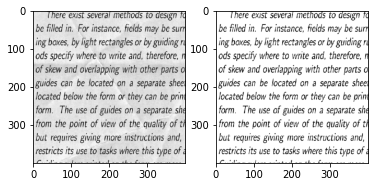

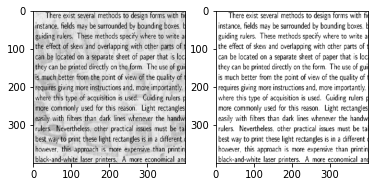

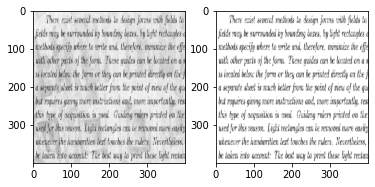

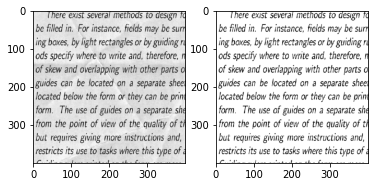

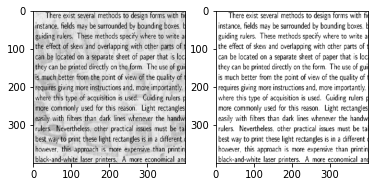

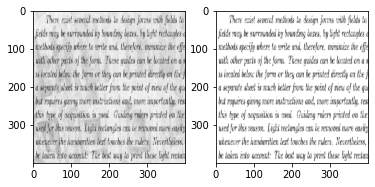

In [23]:
# Display some training images and target images

from matplotlib import pyplot as plt

n = 0
for train, target in zip(train_input_image_generator, train_target_image_generator):
    plt.figure()
    plt.subplot(121)
    plt.imshow((train[0][:,:,0]*255).astype('uint8'),cmap='gray')
    plt.subplot(122)
    plt.imshow((target[0][:,:,0]*255).astype('uint8'),cmap='gray')
    n+=1
    if n >5:
        break

In [24]:
# Create model

def autoencoder():

    model = Sequential()

    # input layer
    model.add(layers.Input(shape=(400,400, 1)))

    # encoder section
    model.add(layers.Conv2D(32, (3, 3), activation='relu',strides=2,padding='same'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu',strides=2,padding='same'))
    model.add(layers.BatchNormalization())
    

    # decoder section
    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu',strides=2,padding='same'))
    model.add(layers.Conv2DTranspose(32, (3, 3), activation='relu',strides=2,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(1, (3, 3), activation='sigmoid',strides=1, padding='same'))

    # compile model
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    #print model summary
    model.summary()

    return model

# create model
model = autoencoder()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 200, 200, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 400, 400, 32)     18464     
 ranspose)                                                       
                                                        

In [25]:
torch.cuda.empty_cache()

In [26]:
# fit model

training_sample = train_input_image_generator.samples

model.fit(
        train_generator,
        steps_per_epoch=np.ceil(training_sample/batch_size),
        epochs=epoch_size,
        )

Epoch 1/150
3/3 [==============================] - 13s 782ms/step - loss: 0.2539 - mae: 0.4506
Epoch 2/150
3/3 [==============================] - 1s 328ms/step - loss: 0.1867 - mae: 0.3679
Epoch 3/150
3/3 [==============================] - 1s 323ms/step - loss: 0.1558 - mae: 0.3274
Epoch 4/150
3/3 [==============================] - 1s 320ms/step - loss: 0.1315 - mae: 0.2925
Epoch 5/150
3/3 [==============================] - 1s 327ms/step - loss: 0.1124 - mae: 0.2587
Epoch 6/150
3/3 [==============================] - 1s 325ms/step - loss: 0.0979 - mae: 0.2323
Epoch 7/150
3/3 [==============================] - 1s 324ms/step - loss: 0.0873 - mae: 0.2142
Epoch 8/150
3/3 [==============================] - 2s 324ms/step - loss: 0.0789 - mae: 0.2007
Epoch 9/150
3/3 [==============================] - 2s 335ms/step - loss: 0.0719 - mae: 0.1894
Epoch 10/150
3/3 [==============================] - 1s 324ms/step - loss: 0.0658 - mae: 0.1795
Epoch 11/150
3/3 [==============================] - 1s 325

In [27]:
!pwd

/content


In [29]:
%cd /content/working/

/content/working


In [30]:
# Save the weights

# tf.keras.models.save_model(
#     model,
#     '/content/sample_data',
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True
# )

model.save('/content/sample_data')

In [30]:
!git clone https://github.com/kwcckw/shabby_images/

Cloning into 'shabby_images'...
remote: Enumerating objects: 2150, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2150 (delta 0), reused 4 (delta 0), pack-reused 2146
Receiving objects: 100% (2150/2150), 326.31 MiB | 39.44 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (2146/2146), done.


In [31]:
test_input_path = "/content/working/shabby_images/Datasets/test"

In [32]:
def preprocess(path):

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = np.asarray(img, dtype="float32")
    img = img/255.0 #Scaling the pixel values
    
    return img.reshape(400,400,1)

In [33]:
# get testing image

img_test_path = sorted(glob.glob(test_input_path+'/input/*'))

test_imgs = []
for file_path in img_test_path:
    test_imgs.append(preprocess(file_path))
test_imgs = np.asarray(test_imgs)

In [34]:
# get cleaned images using trained model

img_predicted = model.predict(test_imgs, batch_size=2)
for i, (predicted, testing_path) in enumerate(zip(img_predicted, img_test_path)):
    predicted_sequeeze = (np.squeeze(predicted) * 255).astype("uint8")
    cv2.imwrite(test_target_path+os.path.basename(testing_path), predicted_sequeeze)

150/150 [==============================] - 1s 7ms/step


In [35]:
# get cleaned images (optional)

from IPython.display import FileLink

!zip -r output_images.zip /content/working/test/target_images/
FileLink(r'output_images.zip')

  adding: content/working/test/target_images/ (stored 0%)
  adding: content/working/test/target_images/0012-Census-regulations_ftrfaqs.pdf-05.png (deflated 0%)
  adding: content/working/test/target_images/0230-MOH-WomensHealth_MenstrualCycle.pdf-9.png (deflated 14%)
  adding: content/working/test/target_images/0530-EuropeanParliament-Genetically-Modified-Organisms.pdf-12.png (deflated 0%)
  adding: content/working/test/target_images/0562-Census-Demographic_Turning_Points_for_the_US.pdf-10.png (deflated 12%)
  adding: content/working/test/target_images/0229-irs-lafa-20214101f.pdf-18.png (deflated 3%)
  adding: content/working/test/target_images/0507-HSE_tamil.pdf-1.png (deflated 3%)
  adding: content/working/test/target_images/0525-BMJ-dengue-viral-infections.pdf-09.png (deflated 2%)
  adding: content/working/test/target_images/0535-SAGEpub-The-Belief-in-Magic-in-the-Age-of-Science.pdf-09.png (deflated 3%)
  adding: content/working/test/target_images/0149-SEC_formn-1a.pdf-52.png (deflat

/content/working/output_images.zip

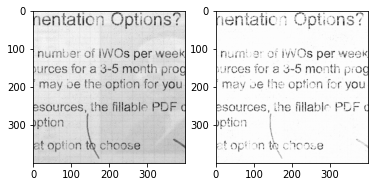

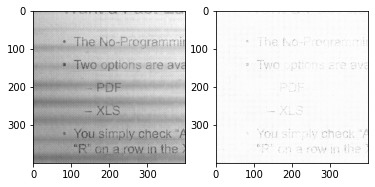

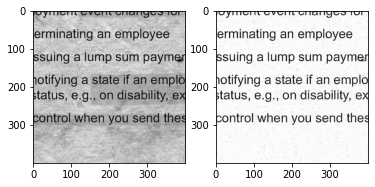

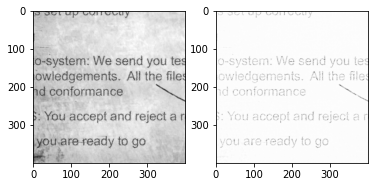

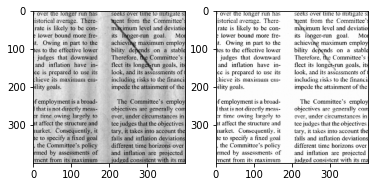

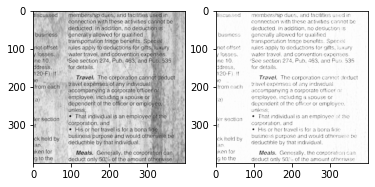

In [36]:
# Display some input testing image and cleaned image from the model

from matplotlib import pyplot as plt

n = 0
for noisy_path in img_test_path:
    
    clean_path = test_target_path + os.path.basename(noisy_path)
    
    img_noisy = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)
    img_clean = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
    
    plt.figure()
    plt.subplot(121)
    plt.imshow(img_noisy,cmap='gray')
    plt.subplot(122)
    plt.imshow(img_clean,cmap='gray')
    n+=1
    if n >5:
        break

In [37]:
# create submission file


cleaned_images_dir = '/content/working/test/target_images/'

def select_pixels(img):
    y,x = img.shape

    pixels = list()

    for i in range(10000):
        pixel = (random.randrange(y), random.randrange(x))

        if pixel not in pixels:
            pixels.append(pixel)

    return pixels


random.seed(0)

cleaned_images = sorted(os.listdir(cleaned_images_dir))

with open("submission.csv", "w") as submission_file:
    submission_file.write("id,predicted\n")

    print("Processing images...")
    filenum = 1
    for image in tqdm(cleaned_images):
        
        img = cv2.imread(cleaned_images_dir + image, cv2.IMREAD_GRAYSCALE)
        pixels = select_pixels(img)

        for pixel in pixels:
            y,x = pixel
            submission_file.write("{}_{}_{},{}\n".format(filenum, y, x, img[y][x]/255.0))

        filenum += 1
    print('Done!')

Processing images...


100%|██████████| 300/300 [06:32<00:00,  1.31s/it]

Done!


In [38]:
# get submission file

from IPython.display import FileLink

FileLink(r'submission.csv')

/content/working/submission.csv

In [39]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
from tensorflow import keras

In [44]:
print(tf.version.VERSION)

2.9.2


In [42]:
# Display the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 200, 200, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 400, 400, 32)     18464     
 ranspose)                                                       
                                                        

In [48]:
# Save the weights
model.save('denoising')